In [52]:
import pandas as pd
import time
from qdrant_client import QdrantClient
import os
import numpy as np
import pprint

from pathlib import Path
from fastparquet import write, ParquetFile
from datetime import datetime
from dotenv import load_dotenv
from qdrant_client.models import Distance, VectorParams

from llama_index.core.node_parser import TokenTextSplitter
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.embeddings.mistralai import MistralAIEmbedding
from llama_index.core import Document, StorageContext, VectorStoreIndex, Settings
from llama_index.llms.mistralai import MistralAI
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.response_synthesizers import ResponseMode
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding


<h2>OpenAI test

In [3]:

# #Test

# llm = OpenAI(
#     model="gpt-3.5-turbo",
#     max_tokens=512,
#     streaming=True,
# )

# response = await llm.acomplete("Hello")
# print(response.text)

<H1>Convert files to parquet for fast processing

In [ ]:
dataframes={}
for doc in Path(r'C:\Projects\RAG_PoC\sbm_rag\data').iterdir():
    if doc.suffix == '.csv':
        dataframes[f"df_{doc.stem}"] = pd.read_csv(doc, low_memory=False)
        dataframes[f"df_{doc.stem}"].to_parquet(rf'C:\Projects\RAG_PoC\sbm_rag\data\parquet\{doc.stem}.parq')

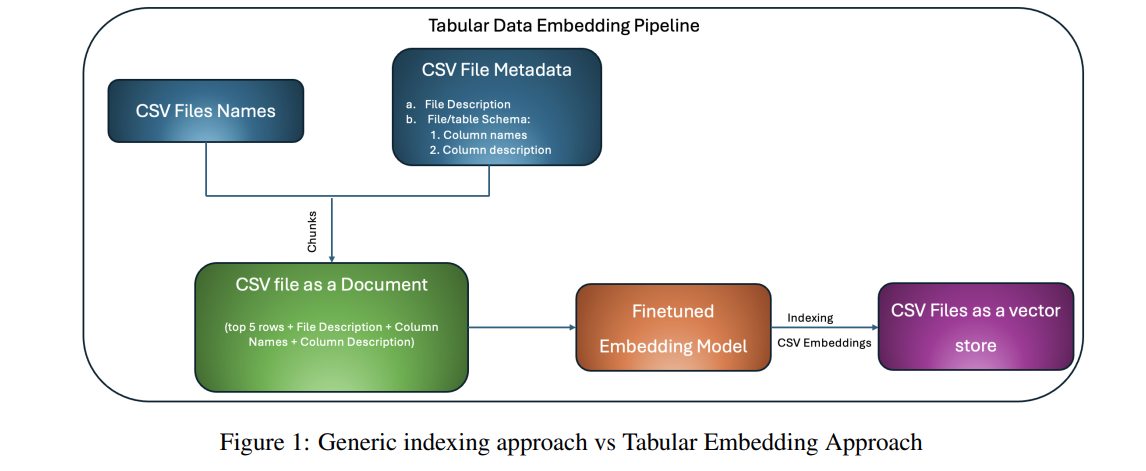

In [5]:
file_names = [doc for doc in Path(r'C:\Projects\RAG_PoC\sbm_rag\data\parquet').iterdir() if doc.suffix == '.parq']
file_names

[WindowsPath('C:/Projects/RAG_PoC/sbm_rag/data/parquet/Appointment_20250306.parq'),
 WindowsPath('C:/Projects/RAG_PoC/sbm_rag/data/parquet/Company_20250306.parq'),
 WindowsPath('C:/Projects/RAG_PoC/sbm_rag/data/parquet/Contact_20250306.parq'),
 WindowsPath('C:/Projects/RAG_PoC/sbm_rag/data/parquet/cont_comp_20250306.parq'),
 WindowsPath('C:/Projects/RAG_PoC/sbm_rag/data/parquet/Currency_20250306.parq'),
 WindowsPath('C:/Projects/RAG_PoC/sbm_rag/data/parquet/Interaction_20250306.parq'),
 WindowsPath('C:/Projects/RAG_PoC/sbm_rag/data/parquet/Intr_Intr_20250306.parq'),
 WindowsPath('C:/Projects/RAG_PoC/sbm_rag/data/parquet/Intr_Oppo_20250306.parq'),
 WindowsPath('C:/Projects/RAG_PoC/sbm_rag/data/parquet/Intr_User_20250306.parq'),
 WindowsPath('C:/Projects/RAG_PoC/sbm_rag/data/parquet/opportunity_20250306.parq'),
 WindowsPath('C:/Projects/RAG_PoC/sbm_rag/data/parquet/Oppo_Comp_20250306.parq'),
 WindowsPath('C:/Projects/RAG_PoC/sbm_rag/data/parquet/Oppo_Cont_20250306.parq'),
 WindowsPath('C

In [40]:
metadata_list = []

for file in file_names:
    pf = ParquetFile(file)
    # Create a more comprehensive metadata entry
    entry = {
        "filename": file.stem,
        "path": str(file),
        "info": pf.info,
        "num_rows": pf.to_pandas().shape[0],  # Corrected: added () to call the method
        "created_at": datetime.now().isoformat()
    }
    metadata_list.append(entry)
    
# Print summary
print(f"Collected metadata from {len(metadata_list)} parquet files")

Collected metadata from 14 parquet files


<h2>chunking table files


In [35]:
# Further processing of csv files
files = [pd.read_parquet(file)[:5] for file in file_names]
# columns = files.columns.tolist()

In [36]:
files

[            appoKey appoInteractionKey                          appoSubject  \
 0  00011HLM0002mVRM   00011GIq0002mVRL                           Demo eLINK   
 1  00011HLM0002mVRi   00011GIq0002mVRh             Kennismakingsgesprek CRM   
 2  00011HLM0002mVRo   00011GIq0002mVRn      Hoever staan ze met dit project   
 3  00011HLM0002mVRq   00011GIq0002mVRp  Opvolging upgrade bij Mevr Coutigny   
 4  00011HLM0002mVS6   00011GIq0002mVS5            Opmaken implementatieplan   
 
         appoSysCreatedDate       appoSysUpdatedDate appoSysCreatedUserKey  \
 0  2004-03-29 13:49:48.000  2004-04-05 13:46:30.000      000102bI00000ncf   
 1  2004-03-31 11:50:15.000  2004-04-06 11:34:47.000      000102bI00000ncf   
 2  2004-03-31 16:20:12.000  2004-03-31 14:29:03.000      000102bI00000ncZ   
 3  2004-03-31 16:30:21.000  2004-04-05 15:40:16.000      000102bI00000ncZ   
 4  2004-04-01 17:31:11.000  2004-04-05 09:13:03.000      000102bI00000ncf   
 
   appoSysUpdatedUserKey            appoBeginDat

In [38]:
columns = [files.columns.tolist() for files in files]

In [12]:
for df_title in dataframes.keys():
    print(df_title)

df_Appointment_20250306
df_Company_20250306
df_Contact_20250306
df_cont_comp_20250306
df_Currency_20250306
df_Interaction_20250306
df_Intr_Intr_20250306
df_Intr_Oppo_20250306
df_Intr_User_20250306
df_opportunity_20250306
df_Oppo_Comp_20250306
df_Oppo_Cont_20250306
df_Reference_20250306
df_User_20250306


In [144]:
dfs = {key: df for key, df in dataframes.items()}

In [145]:
all_row_dicts = []

for df_name, df in dfs.items():
    for index, row in df.iterrows():
        row_dict = row.to_dict()
        row_dict['source_df'] = df_name
        all_row_dicts.append(row_dict)

print(f"Created {len(all_row_dicts)} row dictionaries from small dataframes")
all_row_dicts[0]

Created 1728833 row dictionaries from small dataframes


{'appoKey': '00011HLM0002mVRM',
 'appoInteractionKey': '00011GIq0002mVRL',
 'appoSubject': 'Demo eLINK',
 'appoSysCreatedDate': '2004-03-29 13:49:48.000',
 'appoSysUpdatedDate': '2004-04-05 13:46:30.000',
 'appoSysCreatedUserKey': '000102bI00000ncf',
 'appoSysUpdatedUserKey': '000102bI00000006',
 'appoBeginDate': '2004-03-31 11:00:00.000',
 'appoEndDate': '2004-03-31 14:00:00.000',
 'appoDuration': 10800.0,
 'appoTravelBefore': 3600.0,
 'appoTravelAfter': 3600.0,
 'appoReminder': 0.0,
 'appoLocation': nan,
 'appoPriority': '00010EZE00000kvk',
 'appoMemo': '0x1F8B08000000000000FF73614865C865C8675000D23E0C9E0C7E0CDE40B636102701458A190A188A8074364326431E433A542691210D289A0F1449818A0300115067F746000000',
 'appoEmail': 0,
 'appoAlldayEvent': 0,
 'appoRecurrenceParentKey': nan,
 'appoMemoFormatted': 0,
 'appoOutlookMemo': nan,
 'appoSecurityChanges': nan,
 'appoKeepSecurity': 0,
 'appoOutlookCategory': nan,
 'appoExtMeetingid': nan,
 'appoSynchro': 1,
 'appoUploadState': nan,
 'appoOutlookSu

In [146]:
len(metadata_list)

14

In [147]:
# Assuming row_dicts is your list of dictionaries from the previous cell
documents = []

# First, convert metadata_list items to a dictionary for easier lookup by filename
metadata_dict = {meta['filename']: meta for meta in metadata_list}

for idx, dict_item in enumerate(all_row_dicts):
    # Format as key-value pairs
    text_parts = []
    for key, value in dict_item.items():
        text_parts.append(f"{key}: {value}")
    text_content = "\n".join(text_parts)
    
    # Get file-level metadata from metadata_list
    # Assuming we can identify the source file (adjust as needed)
    source_file = dict_item.get('source_file', 'opportunity_20250306')  # Default if not found
    
    # Create metadata dictionary (not string) combining file metadata and row info
    metadata = {
        # File-level metadata
        **metadata_dict.get(source_file, {}),
        
        # Add row-specific information as metadata
        "row_index": idx,
        "oppo_key": dict_item.get("oppoKey", "unknown"),
        "oppo_name": dict_item.get("oppoName", "")
    }
    
    # Create Document object with proper dictionary metadata
    doc = Document(text=text_content, metadata=metadata)
    documents.append(doc)

print(f"Created {len(documents)} Document objects")
print("\nSample document text:")
print("-" * 40)
print(documents[0].text[:200] + "...")  # Print first 200 chars
print("\nSample metadata:")
print(documents[0].metadata)  # Show metadata is a dictionary, not a string

Created 1728833 Document objects

Sample document text:
----------------------------------------
appoKey: 00011HLM0002mVRM
appoInteractionKey: 00011GIq0002mVRL
appoSubject: Demo eLINK
appoSysCreatedDate: 2004-03-29 13:49:48.000
appoSysUpdatedDate: 2004-04-05 13:46:30.000
appoSysCreatedUserKey: 00...

Sample metadata:
{'filename': 'opportunity_20250306', 'path': 'C:\\Projects\\RAG_PoC\\sbm_rag\\data\\parquet\\opportunity_20250306.parq', 'info': {'name': 'C:/Projects/RAG_PoC/sbm_rag/data/parquet/opportunity_20250306.parq', 'columns': ['oppoKey', 'oppoName', 'oppoSysCreatedDate', 'oppoSysUpdatedDate', 'oppoSysCreatedUserKey', 'oppoUniqueRefIsFixed', 'oppoTargetDate', 'oppoStatus', 'oppoNature', 'oppoSuccessProbability', 'oppoBudget', 'oppoMargin', 'oppoDiscussionDate', 'oppoNegotiationDate', 'oppoConclusionDate', 'oppoCompetitors', 'oppoLostAgainst', 'oppoLostAgainstReason', 'oppoMemo', 'oppoMemoFormatted', 'oppoSysUsedDate', 'oppoBudgetConsolidated', 'oppoDiscountAmount', 'oppoBanner', '

<h2>Document creation

In [148]:
documents[0].text[:200] + "..."

'appoKey: 00011HLM0002mVRM\nappoInteractionKey: 00011GIq0002mVRL\nappoSubject: Demo eLINK\nappoSysCreatedDate: 2004-03-29 13:49:48.000\nappoSysUpdatedDate: 2004-04-05 13:46:30.000\nappoSysCreatedUserKey: 00...'

In [149]:
documents[0]


Document(id_='31bfb14c-49b9-4ef7-af6c-3552ce092b5e', embedding=None, metadata={'filename': 'opportunity_20250306', 'path': 'C:\\Projects\\RAG_PoC\\sbm_rag\\data\\parquet\\opportunity_20250306.parq', 'info': {'name': 'C:/Projects/RAG_PoC/sbm_rag/data/parquet/opportunity_20250306.parq', 'columns': ['oppoKey', 'oppoName', 'oppoSysCreatedDate', 'oppoSysUpdatedDate', 'oppoSysCreatedUserKey', 'oppoUniqueRefIsFixed', 'oppoTargetDate', 'oppoStatus', 'oppoNature', 'oppoSuccessProbability', 'oppoBudget', 'oppoMargin', 'oppoDiscussionDate', 'oppoNegotiationDate', 'oppoConclusionDate', 'oppoCompetitors', 'oppoLostAgainst', 'oppoLostAgainstReason', 'oppoMemo', 'oppoMemoFormatted', 'oppoSysUsedDate', 'oppoBudgetConsolidated', 'oppoDiscountAmount', 'oppoBanner', 'oppoInvoiceSettings', 'oppoTags', 'oppoStatusChangeDate', 'oppoOriginKey', 'oppoSimpleStatus', 'oppoInvestmentAmount', 'oppoCompetitorsMemo', 'oppoPartitionKey', 'oppoClosingReason', 'oppoCurrencyKey', 'oppoConsolidated', 'oppoConsolidatedDa

In [ ]:
# Create nodes to make the documents ingestible by the embedding model
from llama_index.core.node_parser import SimpleNodeParser 
from llama_index.core.schema import TextNode 
import uuid

def create_nodes(documents, mode="custom"):
    if mode == "simple":
        # Basic built-in parser
        parser = SimpleNodeParser.from_defaults(
            chunk_size=2048,
            chunk_overlap=0
        )

        nodes = parser.get_nodes_from_documents(documents)
        print(f"Created {len(nodes)} nodes from {len(documents)} docuements")
        return nodes

    elif mode == "custom":
        # Custom parser
        enhanced_nodes = []

        # Parse document into structured dictionary
        for doc in documents: 
            fields = {}
            for line in doc.text.split("\n"):
                if ":" in line:
                    key, value = (line.split(":", 1))

                    key = key.strip()
                    value = value.strip()

                    if not value: 
                        value = "Nan"
                    
                    fields[key] = value

            # Create a unique ID for each node        
            node = TextNode(
                text=doc.text, 
                metadata={
                    **doc.metadata,
                    "structured_fields": fields,
                    "row_type": "opportunity_data"  
                },
                id_=str(uuid.uuid4())
            )
            enhanced_nodes.append(node)
        print(f"Created {len(enhanced_nodes)} nodes from {len(documents)} documents")
        return enhanced_nodes
    
    elif mode == "index":
        nodes = []

        for doc in documents:
            

In [49]:
nodes = create_nodes(documents)

Created 70 nodes from 70 documents


In [50]:
nodes

[TextNode(id_='f02f4dcb-6b26-4d3d-9ce9-8b976e355e78', embedding=None, metadata={'filename': 'opportunity_20250306', 'path': 'C:\\Projects\\RAG_PoC\\sbm_rag\\data\\parquet\\opportunity_20250306.parq', 'info': {'name': 'C:/Projects/RAG_PoC/sbm_rag/data/parquet/opportunity_20250306.parq', 'columns': ['oppoKey', 'oppoName', 'oppoSysCreatedDate', 'oppoSysUpdatedDate', 'oppoSysCreatedUserKey', 'oppoUniqueRefIsFixed', 'oppoTargetDate', 'oppoStatus', 'oppoNature', 'oppoSuccessProbability', 'oppoBudget', 'oppoMargin', 'oppoDiscussionDate', 'oppoNegotiationDate', 'oppoConclusionDate', 'oppoCompetitors', 'oppoLostAgainst', 'oppoLostAgainstReason', 'oppoMemo', 'oppoMemoFormatted', 'oppoSysUsedDate', 'oppoBudgetConsolidated', 'oppoDiscountAmount', 'oppoBanner', 'oppoInvoiceSettings', 'oppoTags', 'oppoStatusChangeDate', 'oppoOriginKey', 'oppoSimpleStatus', 'oppoInvestmentAmount', 'oppoCompetitorsMemo', 'oppoPartitionKey', 'oppoClosingReason', 'oppoCurrencyKey', 'oppoConsolidated', 'oppoConsolidatedD

In [150]:
# # Create embeddings from the documents

# load_dotenv()
# MISTRAL_API_KEY = os.getenv("MISTRAL_API_KEY")
# model_name = "mistral-embed"
# embed_model = MistralAIEmbedding(api_key=MISTRAL_API_KEY, model_name=model_name)

# llm = OpenAI(
#     model="gpt-3.5-turbo",
#     max_tokens=512,
#     streaming=True,
# )

# embed_model = OpenAIEmbedding(
#     model_name=""
# )

In [108]:
for node in nodes[:10]:
    node.embedding = embed_model.get_text_embedding(node.text)
    print(f"Node id {node.id_} has embedding {node.embedding[:5]}...")
    time.sleep(2)

Node id b271040e-e6d3-4418-ade0-ef9a1331c01f has embedding [-0.0128936767578125, 0.034393310546875, 0.05828857421875, 0.018646240234375, 0.037872314453125]...
Node id b610809f-0b1c-47e9-b8e7-0ecda50aec77 has embedding [-0.03668212890625, 0.026580810546875, 0.047393798828125, 0.01349639892578125, 0.05523681640625]...
Node id c9481e74-c847-4ead-be88-31a7b8059cfc has embedding [-0.0258026123046875, 0.021820068359375, 0.053070068359375, 0.0240325927734375, 0.05572509765625]...
Node id ec19d4f0-65cb-4f72-aed7-8dd76205f05d has embedding [-0.02752685546875, 0.0206451416015625, 0.04815673828125, 0.0201873779296875, 0.056243896484375]...
Node id 074bc62a-4db2-47f0-af5c-845b4d7a276c has embedding [-0.03338623046875, 0.02423095703125, 0.043487548828125, 0.02423095703125, 0.057769775390625]...
Node id 37a2d737-7395-42b2-8d4c-0d338d2949f9 has embedding [-0.039703369140625, 0.0239410400390625, 0.058807373046875, 0.02197265625, 0.06243896484375]...
Node id 8111ca87-4f00-4d3e-8a2f-3be55fa972b0 has emb

In [109]:
nodes[0]

TextNode(id_='b271040e-e6d3-4418-ade0-ef9a1331c01f', embedding=[-0.0128936767578125, 0.034393310546875, 0.05828857421875, 0.018646240234375, 0.037872314453125, 0.01238250732421875, 0.02593994140625, 0.00714111328125, -0.0028228759765625, -0.00324249267578125, 0.004482269287109375, 0.07403564453125, -0.0305938720703125, 0.00399017333984375, -0.07025146484375, 0.0489501953125, -0.02069091796875, 0.031463623046875, 0.06060791015625, 0.01172637939453125, -0.0007557868957519531, -0.019378662109375, -0.0390625, 0.0032062530517578125, -0.005611419677734375, -0.004535675048828125, -0.012237548828125, -0.034088134765625, -0.042266845703125, -0.0142059326171875, 0.0175628662109375, -0.0177001953125, -0.01442718505859375, 0.03497314453125, -0.006046295166015625, -0.03656005859375, -0.01500701904296875, -0.038482666015625, 0.0033512115478515625, 0.023162841796875, -0.003879547119140625, -0.02142333984375, -0.01471710205078125, 0.0039520263671875, -0.029876708984375, -0.01056671142578125, -0.012969

<h1>Create indexes

In [110]:
load_dotenv(r"C:\Projects\RAG_PoC\sbm_rag\.env")
QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")
print(QDRANT_API_KEY[:10])

eyJhbGciOi


In [111]:
qdrant_client = QdrantClient(
    url="https://01b967e9-5470-458f-9403-f0f673654707.europe-west3-0.gcp.cloud.qdrant.io:6333", 
    api_key=QDRANT_API_KEY,
) 

print(qdrant_client.get_collections())

collections=[CollectionDescription(name='sbm_tabular_rag')]


In [112]:
# qdrant_client.create_collection(collection_name="sbm_tabular_rag", vectors_config=VectorParams(size=len(nodes[0].embedding), distance=Distance.COSINE),) #collection already exists

In [113]:
if not hasattr(nodes[0], 'embedding') or nodes[0].embedding is None:
    print("Warning: Nodes don't have embeddings. They'll be generated during indexing.")

In [114]:
collection_name = "sbm_tabular_rag"
vector_dimension = 1024

try:
    collection_info = qdrant_client.get_collection(collection_name="sbm_tabular_rag")
    print("Using existing collection:", collection_info)

except Exception as e:
    print(f"Creating new collection: {e}")
    qdrant_client.recreate_collection(
        collection_name=collection_name,
        vectors_config={
            "size": vector_dimension,
            "distance": "Cosine"
        }
    )

Using existing collection: status=<CollectionStatus.GREEN: 'green'> optimizer_status=<OptimizersStatusOneOf.OK: 'ok'> vectors_count=None indexed_vectors_count=0 points_count=1032 segments_count=2 config=CollectionConfig(params=CollectionParams(vectors=VectorParams(size=1024, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None, datatype=None, multivector_config=None), shard_number=1, sharding_method=None, replication_factor=1, write_consistency_factor=1, read_fan_out_factor=None, on_disk_payload=True, sparse_vectors=None), hnsw_config=HnswConfig(m=16, ef_construct=100, full_scan_threshold=10000, max_indexing_threads=0, on_disk=False, payload_m=None), optimizer_config=OptimizersConfig(deleted_threshold=0.2, vacuum_min_vector_number=1000, default_segment_number=0, max_segment_size=None, memmap_threshold=None, indexing_threshold=20000, flush_interval_sec=5, max_optimization_threads=None), wal_config=WalConfig(wal_capacity_mb=32, wal_segments_ahead

In [115]:
# qdrant_client.recreate_collection(
#     collection_name=collection_name,
#     vectors_config={
#         "size": vector_dimension,
#         "distance": "Cosine"
#     }
# )

In [116]:
vector_store = QdrantVectorStore(client=qdrant_client, collection_name="sbm_tabular_rag")
storage_context = StorageContext.from_defaults(vector_store=vector_store)

In [117]:
nodes[0].embedding

[-0.0128936767578125,
 0.034393310546875,
 0.05828857421875,
 0.018646240234375,
 0.037872314453125,
 0.01238250732421875,
 0.02593994140625,
 0.00714111328125,
 -0.0028228759765625,
 -0.00324249267578125,
 0.004482269287109375,
 0.07403564453125,
 -0.0305938720703125,
 0.00399017333984375,
 -0.07025146484375,
 0.0489501953125,
 -0.02069091796875,
 0.031463623046875,
 0.06060791015625,
 0.01172637939453125,
 -0.0007557868957519531,
 -0.019378662109375,
 -0.0390625,
 0.0032062530517578125,
 -0.005611419677734375,
 -0.004535675048828125,
 -0.012237548828125,
 -0.034088134765625,
 -0.042266845703125,
 -0.0142059326171875,
 0.0175628662109375,
 -0.0177001953125,
 -0.01442718505859375,
 0.03497314453125,
 -0.006046295166015625,
 -0.03656005859375,
 -0.01500701904296875,
 -0.038482666015625,
 0.0033512115478515625,
 0.023162841796875,
 -0.003879547119140625,
 -0.02142333984375,
 -0.01471710205078125,
 0.0039520263671875,
 -0.029876708984375,
 -0.01056671142578125,
 -0.012969970703125,
 -0.03

In [118]:
embedded_nodes_idx = len([node for node in nodes if node.embedding is not None])

In [119]:
#Create the index

index = VectorStoreIndex(
    nodes=nodes[:embedded_nodes_idx],
    storage_context=storage_context,
    show_progress=True
)

Generating embeddings: 0it [00:00, ?it/s]


In [120]:
qdrant_client.get_collection(collection_name="sbm_tabular_rag")

CollectionInfo(status=<CollectionStatus.GREEN: 'green'>, optimizer_status=<OptimizersStatusOneOf.OK: 'ok'>, vectors_count=None, indexed_vectors_count=0, points_count=1042, segments_count=2, config=CollectionConfig(params=CollectionParams(vectors=VectorParams(size=1024, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None, datatype=None, multivector_config=None), shard_number=1, sharding_method=None, replication_factor=1, write_consistency_factor=1, read_fan_out_factor=None, on_disk_payload=True, sparse_vectors=None), hnsw_config=HnswConfig(m=16, ef_construct=100, full_scan_threshold=10000, max_indexing_threads=0, on_disk=False, payload_m=None), optimizer_config=OptimizersConfig(deleted_threshold=0.2, vacuum_min_vector_number=1000, default_segment_number=0, max_segment_size=None, memmap_threshold=None, indexing_threshold=20000, flush_interval_sec=5, max_optimization_threads=None), wal_config=WalConfig(wal_capacity_mb=32, wal_segments_ahead=0), q

In [174]:
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
print(OPENAI_API_KEY[:10])

sk-proj-B9


In [121]:
mistral_llm = MistralAI(
    api_key=MISTRAL_API_KEY,
    model="mistral-large-latest",
)

Settings.llm = mistral_llm

In [122]:
Settings.embed_model = embed_model

<H2>Retrieve embeddings

In [123]:
# Get the index from vector store

index = VectorStoreIndex.from_vector_store(
    vector_store=vector_store,
    show_progress=True,
    storage_context=storage_context,
)

In [124]:
retriever = index.as_retriever(
    similarity_top_k=5,
    verbose=True,
    embed_model=embed_model
    )

In [125]:
query_engine = RetrieverQueryEngine.from_args(
    retriever=retriever,
    llm=mistral_llm,
    response_mode=ResponseMode.TREE_SUMMARIZE,
    node_postprocessors=[], 
    streaming=True
)



response = query_engine.query("What is the latest opportunity in the database ? Give me the creation date of this one aswell as it's oppoKey.")

print(f"Response: {response}")

Response: The latest opportunity in the database is "Yuse eLINK". The creation date for this opportunity is 2004-03-31 10:59:54.000, and its oppoKey is 00010qY40000wK5A.


In [126]:
response = query_engine.query("Give the 3 opportunities with the biggest budget, give the opponame, oppoBudget and oppoKey")

print(f"Response: {response}")

Response: The three opportunities with the biggest budgets are:

1. **Opportunity Name:** Yuse eLINK
   - **Budget:** 9000.0
   - **Key:** 00010qY40000wK5A

2. **Opportunity Name:** AC2S De Post
   - **Budget:** 8750.0
   - **Key:** 00010qY40000wK5D

3. **Opportunity Name:** Aandarta - 10 User (Real Estate)
   - **Budget:** 0.0
   - **Key:** 00010qY40000wK55


In [128]:
response = query_engine.query("Give me the 5 opportunities with the biggest budget, give the oppoName, oppoBudget and oppoKey")

In [ ]:
response

StreamingResponse(response_gen=<generator object stream_chat_response_to_tokens.<locals>.gen at 0x000001D806D4D8A0>, source_nodes=[NodeWithScore(node=TextNode(id_='e9ff1bc4-ffaa-427d-8626-29121f408ea4', embedding=None, metadata={'filename': 'opportunity_20250306', 'num_rows': 133696, 'num_columns': 43, 'column_names': ['oppoKey', 'oppoName', 'oppoSysCreatedDate', 'oppoSysUpdatedDate', 'oppoSysCreatedUserKey', 'oppoUniqueRefIsFixed', 'oppoTargetDate', 'oppoStatus', 'oppoNature', 'oppoSuccessProbability', 'oppoBudget', 'oppoMargin', 'oppoDiscussionDate', 'oppoNegotiationDate', 'oppoConclusionDate', 'oppoCompetitors', 'oppoLostAgainst', 'oppoLostAgainstReason', 'oppoMemo', 'oppoMemoFormatted', 'oppoSysUsedDate', 'oppoBudgetConsolidated', 'oppoDiscountAmount', 'oppoBanner', 'oppoInvoiceSettings', 'oppoTags', 'oppoStatusChangeDate', 'oppoOriginKey', 'oppoSimpleStatus', 'oppoInvestmentAmount', 'oppoCompetitorsMemo', 'oppoPartitionKey', 'oppoClosingReason', 'oppoCurrencyKey', 'oppoConsolidate

In [129]:
response = query_engine.query("How many opportunities are there in the database ?")
print(response)

There are 133,696 opportunities in the database.


In [130]:
response = query_engine.query("Display first three opportunities")
print(response)

The first three opportunities are:

1. **Opportunity Key:** 00010qY40000wK55
   - **Name:** Aandarta - 10 User (Real Estate)
   - **Created Date:** 2016-01-04 10:25:23.000
   - **Updated Date:** 2019-02-26 07:33:31.000
   - **Status:** 00010EZE000XmyIB
   - **Success Probability:** 0.0

2. **Opportunity Key:** 00010qY40000wK56
   - **Name:** Not available
   - **Created Date:** Not available
   - **Updated Date:** Not available
   - **Status:** Not available
   - **Success Probability:** Not available

3. **Opportunity Key:** 00010qY40000wK57
   - **Name:** Not available
   - **Created Date:** Not available
   - **Updated Date:** Not available
   - **Status:** Not available
   - **Success Probability:** Not available


In [133]:
response = query_engine.query("What can you say about opportunity 00010qY40000wK5D")
print(response)

The opportunity 00010qY40000wK5D, known as "AC2S De Post," was created on April 1, 2004, and last updated on February 15, 2019. It had a budget of 8,750.0 with a success probability of 10.0%. The target date for this opportunity was set to September 30, 2004, which was also its conclusion date. The opportunity was archived, and its last used date was recorded as April 16, 2024. The quote sync was enabled for this opportunity.


In [135]:
response = query_engine.query("How many tables are in the database ? What are their names ? How are they related ?")
print(response)

There are 4 tables in the database. Their names are:

1. Company
2. Intr_User
3. Intr_Oppo
4. User

The relationships between these tables can be inferred from the keys used in each table. Here's how they are related:

- **Company and Intr_User**: These tables may be related through the `compSysCreatedUserKey` and `compSysUpdatedUserKey` columns in the Company table, which could correspond to the `intruserUserKey` column in the Intr_User table.

- **Intr_User and Intr_Oppo**: These tables are related through the `intruserInteractionKey` column in the Intr_User table and the `introppoInteractionKey` column in the Intr_Oppo table.

- **Intr_User and User**: These tables are related through the `intruserUserKey` column in the Intr_User table and the `userKey` column in the User table.

- There is no direct relation between Company and Intr_Oppo, Company and User, Intr_Oppo and User.


In [136]:
response = query_engine.query("Is there a table named 'opportunity' ? If yes, what are the columns of this table ?")
print(response)

Yes, there is a table named 'opportunity'. The columns of this table are:

- oppoKey
- oppoName
- oppoSysCreatedDate
- oppoSysUpdatedDate
- oppoSysCreatedUserKey
- oppoUniqueRefIsFixed
- oppoTargetDate
- oppoStatus
- oppoNature
- oppoSuccessProbability
- oppoBudget
- oppoMargin
- oppoDiscussionDate
- oppoNegotiationDate
- oppoConclusionDate
- oppoCompetitors
- oppoLostAgainst
- oppoLostAgainstReason
- oppoMemo
- oppoMemoFormatted
- oppoSysUsedDate
- oppoBudgetConsolidated
- oppoDiscountAmount
- oppoBanner
- oppoInvoiceSettings
- oppoTags
- oppoStatusChangeDate
- oppoOriginKey
- oppoSimpleStatus
- oppoInvestmentAmount
- oppoCompetitorsMemo
- oppoPartitionKey
- oppoClosingReason
- oppoCurrencyKey
- oppoConsolidated
- oppoConsolidatedDate
- oppoType
- oppoSysReplicationDate
- oppoSysReplicationUserKey
- oppoArchived
- oppoCommitment
- oppoRole
- oppoQuoteSyncEnabled


In [149]:
response = query_engine.query("How many different files are in the database ?")
print(response)

There are 10 different files in the database.


In [152]:
response = query_engine.query("How many tables are in the database ? What are the table's name ? Which file compose each table and which file isn't used anywhere?")
print(response)

There are 4 tables in the database. The tables are named:

1. Company
2. Reference
3. Intr_User
4. User

The files that compose each table are as follows:

1. Company: Company_20250306
2. Reference: Reference_20250306
3. Intr_User: Intr_User_20250306
4. User: User_20250306

There are no files listed that aren't used in any table.


In [154]:
response = query_engine.query("Is there a table opportunity in the database ? How many tables are in the database ? What are the tables names ?")
print(response)

Yes, there is a table opportunity in the database. There are 5 tables in the database. The table names are:

1. opportunity
2. company
3. oppo_cont
4. oppo_comp
5. intr_oppo


In [156]:
response = query_engine.query("How many database are in the cluster ? How are they named ?")
print(response)

There are 4 databases in the cluster. The names of the databases are:

1. Company_20250306
2. Reference_20250306
3. Intr_User_20250306
4. Intr_User_20250306 (Note: There are two databases with the same name)


In [ ]:
response = query_engine.query("Is there an opportunity with more than 0.0 in the oppoBudget column ?")
print(response)

No, there is no opportunity with more than 0.0 in the oppoBudget column.


In [ ]:
response = query_engine.query("Give 3 contacts")
print(response)

Maite Irigaray, App Business with, Anissa Buyl


In [ ]:
response = query_engine.query("what are the characteristics of the opportunities ?")
print(response)

Opportunities have several characteristics, including:

- **Identifiers and Dates**: Each opportunity has a unique key (oppoKey) and name (oppoName). There are also system dates for creation (oppoSysCreatedDate), updates (oppoSysUpdatedDate), and usage (oppoSysUsedDate). Additionally, there are dates for discussions (oppoDiscussionDate), negotiations (oppoNegotiationDate), and conclusions (oppoConclusionDate).

- **Status and Probability**: Opportunities have a status (oppoStatus) and a simple status (oppoSimpleStatus). The success probability is indicated by oppoSuccessProbability.

- **Financial Details**: These include the budget (oppoBudget), margin (oppoMargin), discount amount (oppoDiscountAmount), investment amount (oppoInvestmentAmount), and consolidated budget (oppoBudgetConsolidated).

- **Competition and Outcome**: Information about competitors (oppoCompetitors), reasons for losing against a competitor (oppoLostAgainstReason), and closing reasons (oppoClosingReason) are trac

In [ ]:
response = query_engine.query("Which opportunities are in the pipeline ?")
print(response)

To determine which opportunities are in the pipeline, we need to identify opportunities that are still active or open. Typically, opportunities in the pipeline have statuses such as "Open," "In Progress," or other indicators that they are not yet closed or lost.

Without specific status labels provided, it's challenging to pinpoint exact opportunities. However, opportunities with statuses that do not indicate closure or loss, such as "Lost" or "Won," are generally considered to be in the pipeline. If you have specific status labels or additional filters, please provide them for a more accurate response.


In [ ]:
# We only have one opportunity in the dataset, indexing or nodes has to be reworked
# It works, but the response is not accurate, we need to optimize the pre-retrieval process

<H1> Ingest new nodes

In [ ]:
# Single node ingestion

new_document = Document(text="This is a new document, for testing purposes with the code : Test successful")

index.insert(new_document)

Parsing nodes: 100%|██████████| 1/1 [00:00<00:00, 1529.09it/s]


In [ ]:
response = query_engine.query("What is the code of the new document ? If there are multiple solutions, give them all.")
print(response)

The codes for the new documents are:
- 11100110011AAA
- Test successful


In [ ]:
# Mutlitple nodes ingestion

test_documents = [
    # Technology document
    Document(
        text="Artificial Intelligence (AI) is transforming industries worldwide. Machine learning models like transformers have revolutionized natural language processing. Companies are leveraging these technologies to build more intuitive products and services. The future of AI includes developments in multimodal learning and more efficient training methods.",
        metadata={
            "title": "AI Technology Overview",
            "category": "technology",
            "date": "2024-03-15"
        }
    ),
    
    # Science document
    Document(
        text="Black holes are regions of spacetime where gravity is so strong that nothing, including light, can escape. They form when massive stars collapse under their own gravity. In 2019, the Event Horizon Telescope captured the first image of a black hole in the galaxy M87. Scientists continue to study these phenomena to better understand the fundamental laws of physics.",
        metadata={
            "title": "Black Holes Explained",
            "category": "science",
            "date": "2024-02-28"
        }
    ),
    
    # History document
    Document(
        text="The Renaissance was a period of European cultural, artistic, political, and scientific rebirth that marked the transition from the Middle Ages to modernity. Beginning in Italy in the 14th century, it spread across Europe by the 16th century. Renaissance artists like Leonardo da Vinci and Michelangelo created works that showcase the period's renewed interest in the classical learning of ancient Greece and Rome.",
        metadata={
            "title": "The Renaissance Period",
            "category": "history",
            "date": "2024-01-10"
        }
    ),
    
    # Finance document
    Document(
        text="Cryptocurrency is a digital or virtual currency that uses cryptography for security and operates on decentralized networks based on blockchain technology. Bitcoin, created in 2009, was the first cryptocurrency and remains the most valuable. Other popular cryptocurrencies include Ethereum, which introduced smart contracts, and Solana, known for its high transaction speeds.",
        metadata={
            "title": "Introduction to Cryptocurrency",
            "category": "finance",
            "date": "2024-03-22"
        }
    ),
    
    # Health document
    Document(
        text="Regular exercise has numerous benefits for physical and mental health. It can improve cardiovascular health, strengthen muscles, and enhance cognitive function. The World Health Organization recommends at least 150 minutes of moderate-intensity aerobic activity per week for adults. Different types of exercise include cardio, strength training, flexibility exercises, and balance training.",
        metadata={
            "title": "Benefits of Regular Exercise",
            "category": "health",
            "date": "2024-02-05"
        }
    )
]

In [ ]:
def ingest_and_test(documents):
    """
    Parameters: list of documents to ingest
    """

    index = VectorStoreIndex.from_documents(documents)

    query_engine = index.as_query_engine()

    test_queries = [
        "What are the main applications of AI?",
        "How do black holes form?",
        "Who were important Renaissance artists?",
        "What is cryptocurrency and how does it work?",
        "How much exercise is recommended weekly?"
    ]
    
    index.insert_nodes(documents)

    for query in test_queries:
        print(f"\nQuery: {query}")
        response = query_engine.query(query)
        print(f"Response: {response}")
        time.sleep(2)
    
    return index

In [ ]:
index = ingest_and_test(test_documents)


Query: What are the main applications of AI?
Response: AI is transforming industries worldwide by making products and services more intuitive. It's heavily used in natural language processing through technologies like machine learning models and transformers. Additionally, the future holds promise for applications in multimodal learning and improved training methods for AI models.

Query: How do black holes form?
Response: Black holes form when massive stars collapse under their own gravity.

Query: Who were important Renaissance artists?
Response: Important Renaissance artists include Leonardo da Vinci and Michelangelo.

Query: What is cryptocurrency and how does it work?
Response: Cryptocurrency is a type of digital or virtual currency that secures its transactions using cryptography. It operates independently of a central bank and can be used for online transactions. The technology that underpins cryptocurrency is known as blockchain, which is a decentralized network that ensures t

In [ ]:
index._get_node_with_embedding

<bound method VectorStoreIndex._get_node_with_embedding of <llama_index.core.indices.vector_store.base.VectorStoreIndex object at 0x0000021B51508690>>

In [ ]:
def ingest_from_nodes(nodes, storage_context):
    """ 
    Parameters: 
        nodes: list of nodes to ingest
        storage_context: storage context to use for persistence 

    Returns: 
        The created vector index

    """

    index = VectorStoreIndex(nodes=nodes, 
                             storage_context=storage_context,
                             show_progress=True)
    
    return index

In [ ]:
def add_nodes_to_index(index, nodes):
    """ 
    Add new nodes to an exiting index

    Parameters: 
        index: existing VectorStoreIndex
        new_nodes: list of nodes to add
    Returns:
        The updated index
    """

    for node in nodes:
        index.insert(node)
    
    return index

<h1> Unit tests

In [ ]:
import unittest
from unittest.mock import Mock, patch, MagicMock
import tempfile

from llama_index.core.schema import TextNode


In [ ]:
from numpy import empty


class TestNodeIngestion(unittest.TestCase):
    def setUp(self):
        """Create a temporary directory for testing"""
        self.temp_dir = tempfile.TemporaryDirectory()
        self.persist_dir = self.temp_dir.name

        self.storage_context = StorageContext.from_defaults(persist_dir=self.persist_dir)
        
        self.test_nodes = [
            TextNode(text="Test document 1", id_="node1"),
            TextNode(text="Test document 2", id_="node2"),
            TextNode(text="Test document 3", id_="node3"),
        ]

        self.additional_nodes = [
            TextNode(text="Test document 4", id_="node4"),
            TextNode(text="Test document 5", id_="node5"),
        ]

    def tearDown(self):
        """Clean up after each test"""
        self.temp_dir.cleanup()

    def test_ingest_from_nodes(self):
        """Test creating an index from nodes"""
        index = ingest_from_nodes(self.test_nodes, self.storage_context)
        
        self.assertIsInstance(index, VectorStoreIndex)

        query_engine = index.as_query_engine()

        response = query_engine.query("test node 1")
        self.assertIn("test node", str(response))

        for node in self.test_nodes:
            self.assertIn(node.id_, self.storage_context.docstore.docs)

    
    def test_add_nodes_to_index(self):
        """"Test adding nodes to an existing index"""
        initial_index = ingest_from_nodes(self.test_nodes, self.storage_context)

        updated_index = add_nodes_to_index(initial_index, self.additional_nodes)

        self.assertEqual(id(initial_index), id(updated_index))

        query_engine = updated_index.as_query_engine()

        response = query_engine.query("test node 4")
        self.assertIn("test node", str(response))

        # Verify all nodes are present in the storage context
        for node in self.test_nodes + self.additional_nodes:
            self.assertIn(node.id_, self.storage_context.docstore.docs)

    
    #Edge Cases
    def test_empty_nodes_list(self):
        """Test ingesting an empty list of nodes"""
        index = ingest_from_nodes([], self.storage_context)
        self.assertIsInstance(index, VectorStoreIndex)

    def test_add_empty_nodes_list(self):
        """Test adding an embty list of nodes to an existing index"""

        initial_index = ingest_from_nodes(self.test_nodes, self.storage_context)

        updated_index = add_nodes_to_index(initial_index, [])

        self.assertEqual(id(initial_index), id(updated_index))
        for node in nodes: 
            self.assertIn(node.id_, self.storage_context.docstore.docs)

    @patch('llama_index.core.indices.vector_store.base.VectorStoreIndex')
    def test_show_progress_parameter(self, mock_vector_index):
        """Test that show_progress parameter is passed correctly"""

        # Set up the mock 
        mock_instance = Mock()
        mock_vector_index.return_value = mock_instance

        # Call the function 
        ingest_from_nodes(self.test_nodes, self.storage_context)

        # Verify show_progress was passed 
        mock_vector_index.assert_called_once()
        call_kwargs = mock_vector_index.call_args[1]
        self.assertIn('show_progress', call_kwargs)
        self.assertTrue(call_kwargs['show_progress'])

    def test_node_integration_from_documents(self):
        """Test integration with node parser from documents"""
        # Create sample documents
        documents = [
            Document(text="Document 1 content for testing"),
            Document(text="Document 2 content for testing")
        ]
        
        # Parse documents into nodes
        parser = SimpleNodeParser()
        parsed_nodes = parser.get_nodes_from_documents(documents)
        
        # Ingest parsed nodes
        index = ingest_from_nodes(parsed_nodes, self.storage_context)
        
        # Verify index was created with the nodes
        self.assertIsInstance(index, VectorStoreIndex)
        
        # Query to verify content was indexed
        query_engine = index.as_query_engine()
        response = query_engine.query("document content")
        self.assertIn("document", str(response).lower())

        

In [ ]:
# First, define all your functions and test classes in notebook cells
# (copy all the code from the artifact)

# Then add a cell with this code to run the tests
import unittest
import sys
from io import StringIO

# Capture the output
test_output = StringIO()
runner = unittest.TextTestRunner(stream=test_output)

# Run the tests
test_suite = unittest.TestLoader().loadTestsFromTestCase(TestNodeIngestion)
result = runner.run(test_suite)

# # Optional: also run the integration tests
# integration_suite = unittest.TestLoader().loadTestsFromTestCase(TestRealDataIntegration)
# integration_result = runner.run(integration_suite)

# Print results
print(test_output.getvalue())
print(f"Tests run: {result.testsRun}, Errors: {len(result.errors)}, Failures: {len(result.failures)}")


EEEEEE
ERROR: test_add_empty_nodes_list (__main__.TestNodeIngestion.test_add_empty_nodes_list)
Test adding an embty list of nodes to an existing index
----------------------------------------------------------------------
Traceback (most recent call last):
  File "C:\Users\axel.grille\AppData\Local\Temp\ipykernel_36052\2874115377.py", line 10, in setUp
    self.storage_context = StorageContext.from_defaults(persist_dir=self.persist_dir)
                           ^^^^^^^^^^^^^^
NameError: name 'StorageContext' is not defined

ERROR: test_add_nodes_to_index (__main__.TestNodeIngestion.test_add_nodes_to_index)
"Test adding nodes to an existing index
----------------------------------------------------------------------
Traceback (most recent call last):
  File "C:\Users\axel.grille\AppData\Local\Temp\ipykernel_36052\2874115377.py", line 10, in setUp
    self.storage_context = StorageContext.from_defaults(persist_dir=self.persist_dir)
                           ^^^^^^^^^^^^^^
NameError: n

<H1> Recursive retriever + Query Engine<H1>


<link>https://docs.llamaindex.ai/en/stable/examples/query_engine/pdf_tables/recursive_retriever/</link>

In [60]:
pip install llama-index-embeddings-openai

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [151]:
from llama_index.experimental.query_engine import PandasQueryEngine
from llama_index.core.schema import IndexNode
from typing import List
from llama_index.embeddings.openai import OpenAIEmbedding
from openai import api_key

load_dotenv(r"C:\Projects\RAG_PoC\sbm_rag\.env")
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"] 

Settings.llm = OpenAI(model="gpt-3.5-turbo")
Settings.embed_model = OpenAIEmbedding(model="text-embedding-3-small")

In [152]:
dataframes.values()

dict_values([                appoKey appoInteractionKey  \
0      00011HLM0002mVRM   00011GIq0002mVRL   
1      00011HLM0002mVRi   00011GIq0002mVRh   
2      00011HLM0002mVRo   00011GIq0002mVRn   
3      00011HLM0002mVRq   00011GIq0002mVRp   
4      00011HLM0002mVS6   00011GIq0002mVS5   
...                 ...                ...   
44304  00011HLM000yyEPl   00011GIq000yyEPm   
44305  00011HLM000yyor4   00011GIq000yyor5   
44306  00011HLM000yyvea   00011GIq000yyveb   
44307  00011HLM000yzTIC   00011GIq000yzTID   
44308  00011HLM000z0Xfn   00011GIq000z0Xfo   

                                            appoSubject  \
0                                            Demo eLINK   
1                              Kennismakingsgesprek CRM   
2                       Hoever staan ze met dit project   
3                   Opvolging upgrade bij Mevr Coutigny   
4                             Opmaken implementatieplan   
...                                                 ...   
44304                

In [ ]:
# # Create a list of DataFrames from the dictionary
# dataframes_list = list(dataframes.values())

In [137]:
llm = OpenAI(model="gpt-4")

df_query_engines = [
    PandasQueryEngine(table_df, llm=llm) for table_df in list(dataframes.values())
]

In [138]:
df_query_engines

In [99]:
response = df_query_engines[0].query("What is the first appoKey ?")
print(str(response))

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
00011HLM0002mVRM


In [95]:
list(dataframes.values())[0].head(5)

,appoKey,appoInteractionKey,appoSubject,appoSysCreatedDate,appoSysUpdatedDate,appoSysCreatedUserKey,appoSysUpdatedUserKey,appoBeginDate,appoEndDate,appoDuration,...,appoExtRecurrent,appoTags,appoKind,appoStatus,appoChannel,appoCategory,appoRecurrenceDefinition,appoMemoGroupwareFormatted,appoIsOnlineMeeting,appoArchived
0,00011HLM0002mVRM,00011GIq0002mVRL,Demo eLINK,2004-03-29 13:49:48.000,2004-04-05 13:46:30.000,000102bI00000ncf,000102bI00000006,2004-03-31 11:00:00.000,2004-03-31 14:00:00.000,10800.0,...,0,NaN,NaN,NaN,00010EZE00000Afb,00010EZE00000Aff,NaN,0,0,1
1,00011HLM0002mVRi,00011GIq0002mVRh,Kennismakingsgesprek CRM,2004-03-31 11:50:15.000,2004-04-06 11:34:47.000,000102bI00000ncf,000102bI00000006,2004-04-01 07:45:00.000,2004-04-01 11:15:00.000,12600.0,...,0,NaN,NaN,NaN,00010EZE00000Afb,00010EZE00000Aff,NaN,0,0,1
2,00011HLM0002mVRo,00011GIq0002mVRn,Hoever staan ze met dit project,2004-03-31 16:20:12.000,2004-03-31 14:29:03.000,000102bI00000ncZ,000102bI00000006,2004-03-31 07:00:00.000,2004-03-31 07:05:00.000,300.0,...,0,NaN,NaN,NaN,00010EZE00000Afb,00010EZE00000Aff,NaN,0,0,1
3,00011HLM0002mVRq,00011GIq0002mVRp,Opvolging upgrade bij Mevr Coutigny,2004-03-31 16:30:21.000,2004-04-05 15:40:16.000,000102bI00000ncZ,000102bI00000006,2004-04-06 11:30:00.000,2004-04-06 11:35:00.000,300.0,...,0,NaN,NaN,NaN,00010EZE00000Afb,00010EZE00000Aff,NaN,0,0,1
4,00011HLM0002mVS6,00011GIq0002mVS5,Opmaken implementatieplan,2004-04-01 17:31:11.000,2004-04-05 09:13:03.000,000102bI00000ncf,000102bI00000006,2004-04-02 11:45:00.000,2004-04-02 17:15:00.000,19800.0,...,0,NaN,NaN,NaN,00010EZE00000Afb,00010EZE00000Aff,NaN,0,0,1


In [100]:
response = df_query_engines[9].query("Which opportunity has the biggest budget ? Give me the oppoKey, oppoName and oppoBudget of this opportunity")
print(str(response))

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
                oppoKey   oppoName  oppoBudget
57469  00010qY40000wZsY  APSIS One   7187720.0


In [102]:
response = df_query_engines[9].query("Give me the schema of the table")
print(str(response))

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
oppoKey                       object
oppoName                      object
oppoSysCreatedDate            object
oppoSysUpdatedDate            object
oppoSysCreatedUserKey         object
oppoUniqueRefIsFixed           int64
oppoTargetDate                object
oppoStatus                    object
oppoNature                    object
oppoSuccessProbability       float64
oppoBudget                   float64
oppoMargin                   float64
oppoDiscussionDate            object
oppoNegotiationDate           object
oppoConclusionDate            object
oppoCompetitors              float64
oppoLostAgainst               object
oppoLostAgainstReason         object
oppoMemo                      object
oppoMemoFormatted              int64
oppoSysUsedDate               object
oppoBudgetConsolidated       float64
oppoDiscountAmo

In [106]:
doc_nodes = Settings.node_parser.get_nodes_from_documents(documents)

In [127]:
df_nodes = [
    IndexNode(text=node.text, metadata=node.metadata, index_id=f"pandas{idx}" ) for idx, node in enumerate(doc_nodes)
]

len(documents)

70

In [123]:
df_nodes[0].text

'appoKey: 00011HLM0002mVRM\nappoInteractionKey: 00011GIq0002mVRL\nappoSubject: Demo eLINK\nappoSysCreatedDate: 2004-03-29 13:49:48.000\nappoSysUpdatedDate: 2004-04-05 13:46:30.000\nappoSysCreatedUserKey: 000102bI00000ncf\nappoSysUpdatedUserKey: 000102bI00000006\nappoBeginDate: 2004-03-31 11:00:00.000\nappoEndDate: 2004-03-31 14:00:00.000\nappoDuration: 10800.0\nappoTravelBefore: 3600.0\nappoTravelAfter: 3600.0\nappoReminder: 0.0\nappoLocation: nan\nappoPriority: 00010EZE00000kvk\nappoMemo: 0x1F8B08000000000000FF73614865C865C8675000D23E0C9E0C7E0CDE40B636102701458A190A188A8074364326431E433A542691210D289A0F1449818A0300115067F746000000\nappoEmail: 0\nappoAlldayEvent: 0\nappoRecurrenceParentKey: nan\nappoMemoFormatted: 0\nappoOutlookMemo: nan\nappoSecurityChanges: nan\nappoKeepSecurity: 0\nappoOutlookCategory: nan\nappoExtMeetingid: nan\nappoSynchro: 1\nappoUploadState: nan\nappoOutlookSubject: nan\nappoIsPrivate: 0\nappoExtRecurrent: 0\nappoTags: nan\nappoKind: nan\nappoStatus: nan\nappoCh

In [129]:
vector_index = VectorStoreIndex(doc_nodes + df_nodes)
vector_retriever = vector_index.as_retriever(similarity_top_k=1)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


In [131]:
# use recursive retriever in our retriever query engine

vector_index0 = VectorStoreIndex(doc_nodes)
vector_query_engine0 = vector_index0.as_query_engine()

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


In [139]:
df_keys = list(dataframes.keys())

df_id_query_engine_mapping = {}

if len(df_keys) == len(df_query_engines):
    for i, key in enumerate(df_keys):
        df_id_query_engine_mapping[key] = df_query_engines[i]
    print(f"Created mapping with {len(df_id_query_engine_mapping)} entries")

else:
    print(f"Error: Number of keys {len(df_keys)} does not match number of engines {len(df_query_engines)}")

Created mapping with 14


In [140]:
from llama_index.core.retrievers import RecursiveRetriever
from llama_index.core.query_engine import RetrieverQueryEngine 
from llama_index.core import get_response_synthesizer


recursive_retriever = RecursiveRetriever(
    "vector",
    retriever_dict={"vector": vector_retriever},
    query_engine_dict=df_id_query_engine_mapping,
    verbose = True,
)

response_synthesizer = get_response_synthesizer(response_mode="compact")

query_engine = RetrieverQueryEngine.from_args(
    recursive_retriever, response_synthesizer=response_synthesizer
)

In [143]:
response = query_engine.query("How many nodes are in the database ?")
print(str(response))

Retrieving with query id None: How many nodes are in the database ?
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
Retrieved node with id, entering: pandas57
Retrieving with query id pandas57: How many nodes are in the database ?


ValueError: Query id pandas57 not found in either `retriever_dict` or `query_engine_dict`.